In [1]:
#路径管理/全局变量
import os
import sys

# 设置为项目根目录（包含 data, pipline 等文件夹的目录）
project_root = os.path.abspath("..")
os.chdir(project_root)
sys.path.append(project_root)
from utils.config import KEYWORDS
from utils.path_helper import get_data_path

#基础模块
import numpy as np
import pandas as pd

#清洗函数，特征工程函数导入
from pipline.pipline import pipeline_house_data
from features_wlh.features_wlh import add_selected_features
#导入训练函数
from model.train_model import train_model
#选择训练函数，自己去调整
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
#训练集划分(已经在train_model里面做过,导入只是告诉你已经做完了)
from sklearn.model_selection import train_test_split
#特征选择
from features_wlh.feature_selector import feature_selection_by_k,select_final_top_features
#from features_wlh.feature_selector import make_advanced_features
#特征值相关性检验
from features_wlh.feature_analysis import plot_feature_correlation
#共线性检验
from features_wlh.feature_vif_validation import check_multicollinearity
#特征值重要性与目标性选择
from features_wlh.FeatureDeepAnalysis import FeatureDeepAnalysis
#评估
from model.evaluate import evaluate_model
from advanced_modify.cross_validation import enhanced_cross_validate

Series of Preparation Before Training

In [2]:
##检查操作路径
import sys
print(sys.executable)
# 直接读取数据
df_cleaned = pd.read_csv(get_data_path("processed_data/house_prices_cleaned.csv"))
# 清洗数据
#df = pd.read_csv(get_data_path("house_prices.csv"))
#df_cleaned = pipeline_house_data(df, keywords=KEYWORDS)
print("清洗后的数据表结构:", df_cleaned.shape)

d:\soft\Python\Python310\python.exe
清洗后的数据表结构: (177572, 33)


C:\Users\K.Hawk\AppData\Local\Temp\ipykernel_15844\3771731593.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cleaned = pd.read_csv(get_data_path("processed_data/house_prices_cleaned.csv"))


In [3]:
#强制重载一下
import importlib
import features_wlh.features_wlh
importlib.reload(features_wlh.features_wlh)  # 强制重新载入模块
from features_wlh.features_wlh import add_selected_features, list_registered_features

In [4]:
q99 = df_cleaned['Amount_clean'].quantile(0.99)
q1 = df_cleaned['Amount_clean'].quantile(0.01)
print(df_cleaned['Amount_clean'].describe())
print(q99)
print(q1)

count    177572.000000
mean         15.924344
std           0.813754
min          13.815512
25%          15.404746
50%          15.869634
75%          16.489659
max          19.113828
Name: Amount_clean, dtype: float64
17.989897843244528
14.285514812209817


Fundenmental Analysis

Analysis with picture and Visualization

Project  of Features and Validation

In [5]:
My_features = [
    "Car_Parking",
    "Bathroom",
    "Furnishing_giving",
    "Transaction_giving",
    "balcony_rank",
    "is_ground",
    "quality_score",
    "location_rank",
    "floor_level_normalize",
    "ownership_score",
    "relative_height",
    "society_level_hot", 
    "std_Carpet_Area",
    "facing_giving",
    "Status_giving",
    "ownership_score",
    "is_multi_bathroom",
    "is_popular_location",
    "floor_area_combo",
    "location_comfort_combo",
    "floor_facing_score",
    "location_ownership_combo",
    "facing_height_combo",
    "area_furnishing_combo"
    ] #一个示例，训练的时候根据特征分析自己去选


#添加并检查
df_cleaned_features = add_selected_features(df_cleaned, features_to_use = My_features)
print("当前 df_cleaned_features 的列有：", df_cleaned_features.columns.tolist())
missing = [feat for feat in My_features if feat not in df_cleaned_features.columns]
print("缺失的特征：", missing)
df_cleaned_features.isnull().sum()
print("✅ 当前注册的特征值函数有：", list(list_registered_features()))
print("当前特征值是否为空",df_cleaned_features[My_features].isnull().sum())
print("当前特征值数值类型",df_cleaned_features[My_features].dtypes)


当前 df_cleaned_features 的列有： ['Index', 'Price (in rupees)', 'Carpet Area', 'Status', 'Transaction', 'Furnishing', 'Balcony', 'is_prime_location', 'has_proximity', 'is_well_planned', 'is_new', 'is_resale', 'is_affordable', 'is_deal', 'is_spacious', 'is_luxury', 'is_gated', 'has_amenities', 'has_green_space', 'is_marketing_strong', 'location_encoded', 'floor_level', 'max_floor', 'is_ground', 'is_basement', 'relative_height', 'col_facing_score', 'col_overlooking_score', 'society_level', 'col_Bathroom_score', 'col_car_parking_score', 'ownership_score', 'Amount_clean', 'Car_Parking', 'Bathroom', 'Furnishing_giving', 'Transaction_giving', 'balcony_rank', 'quality_score', 'location_rank', 'location_level', 'floor_level_normalize', 'society_level_hot', 'std_Carpet_Area', 'facing_giving', 'Status_giving', 'is_multi_bathroom', 'is_popular_location', 'floor_area_combo', 'location_comfort_combo', 'floor_facing_score', 'location_ownership_combo', 'facing_height_combo', 'area_furnishing_combo']
缺失的特征

In [6]:
print('\n'.join(df_cleaned_features.columns))

Index
Price (in rupees)
Carpet Area
Status
Transaction
Furnishing
Balcony
is_prime_location
has_proximity
is_well_planned
is_new
is_resale
is_affordable
is_deal
is_spacious
is_luxury
is_gated
has_amenities
has_green_space
is_marketing_strong
location_encoded
floor_level
max_floor
is_ground
is_basement
relative_height
col_facing_score
col_overlooking_score
society_level
col_Bathroom_score
col_car_parking_score
ownership_score
Amount_clean
Car_Parking
Bathroom
Furnishing_giving
Transaction_giving
balcony_rank
quality_score
location_rank
location_level
floor_level_normalize
society_level_hot
std_Carpet_Area
facing_giving
Status_giving
is_multi_bathroom
is_popular_location
floor_area_combo
location_comfort_combo
floor_facing_score
location_ownership_combo
facing_height_combo
area_furnishing_combo


Easy Chioce of your features

In [ ]:
print("打印df_cleaned表头")
print(df_cleaned_features.columns.tolist())
#筛选特征值
print("step1---筛选特征值")
# 分析每个特征数下的最优组合
df_result, model_name_str, model_cls_used = feature_selection_by_k(df_cleaned[My_features], target_col = df_cleaned["Amount_clean"], max_k=20, rank_features=10, model_cls = RandomForestRegressor)
print(df_result)
# 直接选出最终最重要的15个特征
top_features = select_final_top_features(df_cleaned[My_features], target_col = df_cleaned["Amount_clean"], max_k=20, top_k=15, model_cls = model_cls_used)
for feature in top_features:
    print(feature)

打印df_cleaned表头
['Index', 'Price (in rupees)', 'Carpet Area', 'Status', 'Transaction', 'Furnishing', 'Balcony', 'is_prime_location', 'has_proximity', 'is_well_planned', 'is_new', 'is_resale', 'is_affordable', 'is_deal', 'is_spacious', 'is_luxury', 'is_gated', 'has_amenities', 'has_green_space', 'is_marketing_strong', 'location_encoded', 'floor_level', 'max_floor', 'is_ground', 'is_basement', 'relative_height', 'col_facing_score', 'col_overlooking_score', 'society_level', 'col_Bathroom_score', 'col_car_parking_score', 'ownership_score', 'Amount_clean', 'Car_Parking', 'Bathroom', 'Furnishing_giving', 'Transaction_giving', 'balcony_rank', 'quality_score', 'location_rank', 'location_level', 'floor_level_normalize', 'society_level_hot', 'std_Carpet_Area', 'facing_giving', 'Status_giving', 'is_multi_bathroom', 'is_popular_location', 'floor_area_combo', 'location_comfort_combo', 'floor_facing_score', 'location_ownership_combo', 'facing_height_combo', 'area_furnishing_combo']
step1---筛选特征值
    

In [8]:
print('\n'.join(str(f) for f in top_features))


std_Carpet_Area
location_rank
Bathroom
floor_level_normalize
floor_area_combo
location_ownership_combo
is_multi_bathroom
society_level_hot
area_furnishing_combo
quality_score
floor_facing_score
facing_height_combo
relative_height
location_comfort_combo
Car_Parking


Check the Quality of Features

step2---特征向量相关性


d:\soft\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


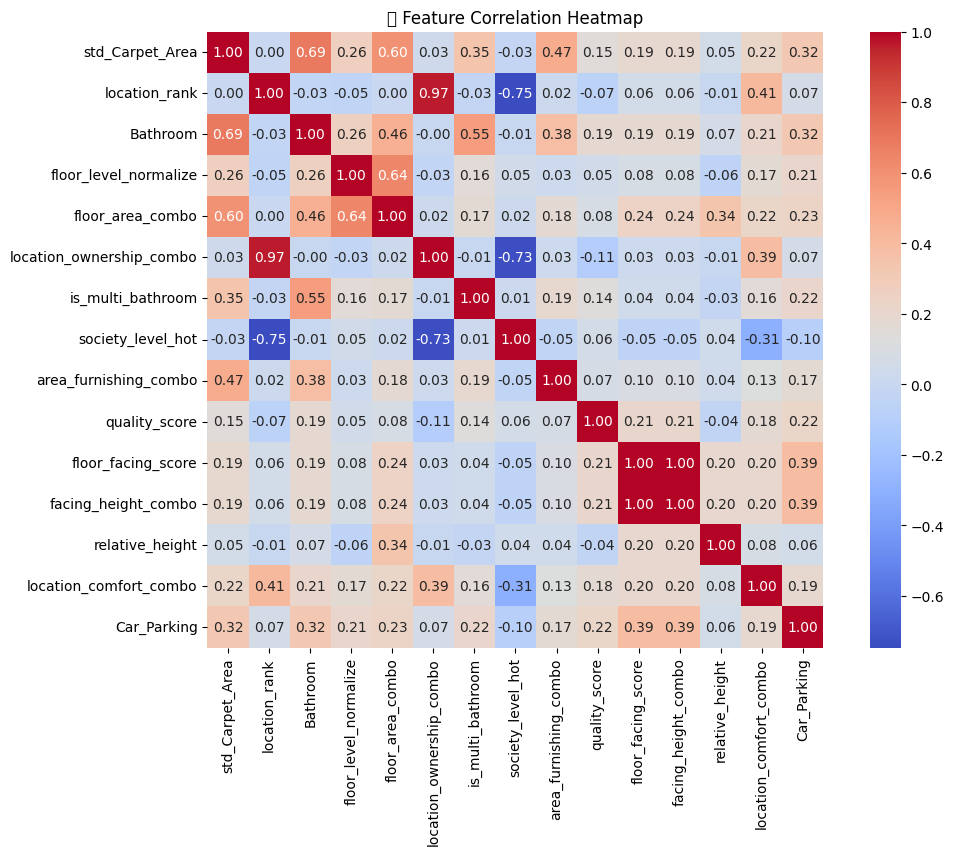

⚠️ 高度相关的特征对（|相关性| > 0.8)：
location_ownership_combo & location_rank → 相关系数: 0.965
facing_height_combo & floor_facing_score → 相关系数: 1.0
🔍 检测到 2 个高相关特征将被删除（阈值：0.8）：
['location_ownership_combo', 'facing_height_combo']
13
step3---VIF检验
🧪 方差膨胀因子(VIF)检测结果:
  feature        VIF
0   const  48.692033
13
step4---特征值重要性排序


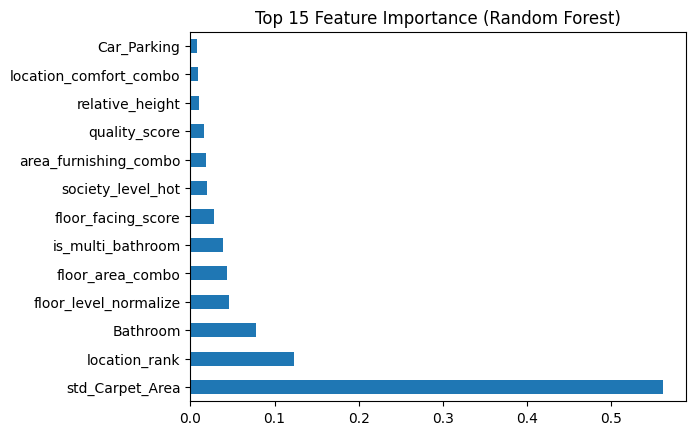

step5---特征值画图


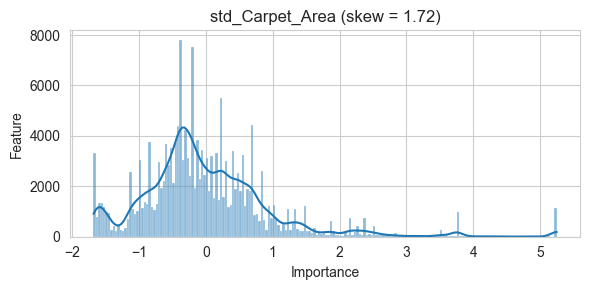

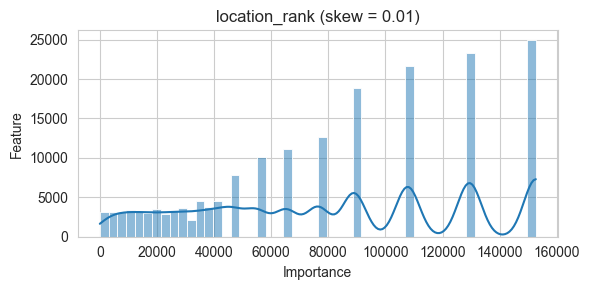

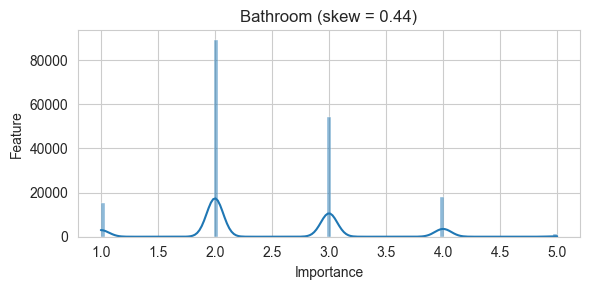

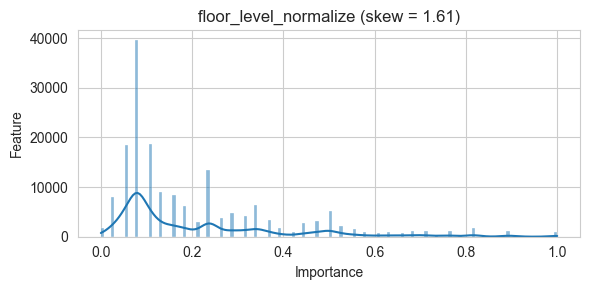

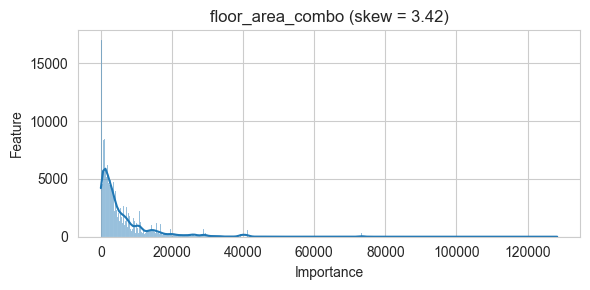

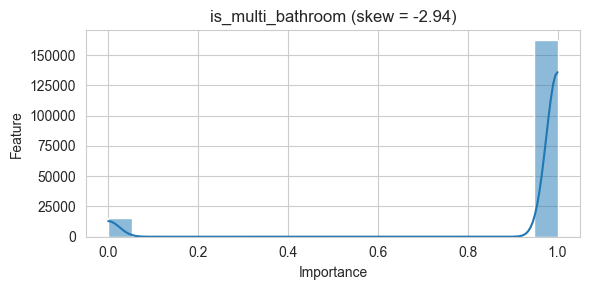

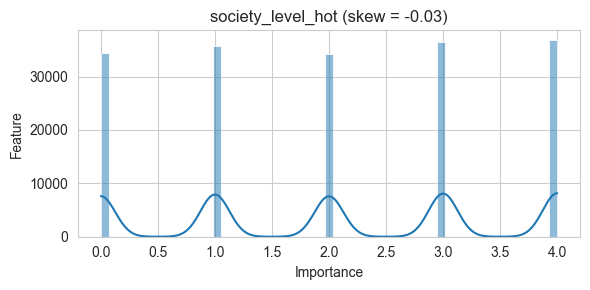

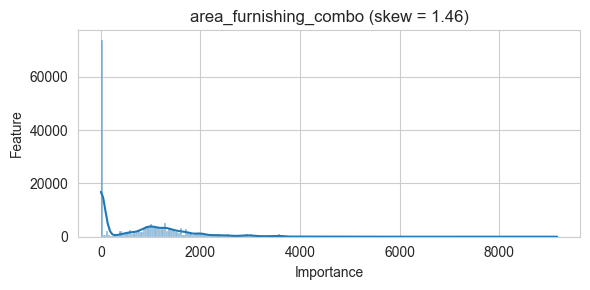

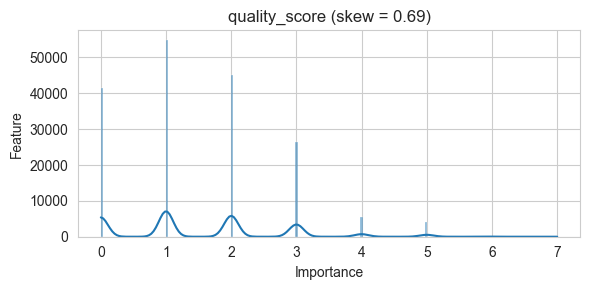

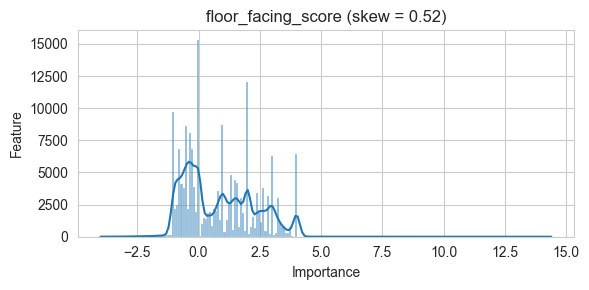

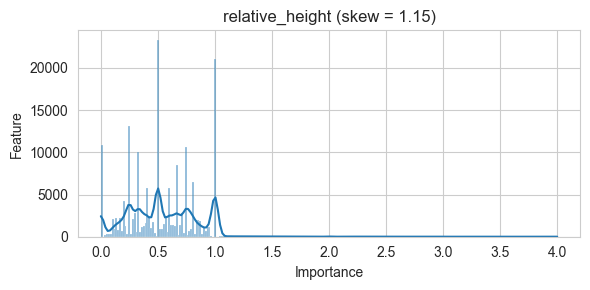

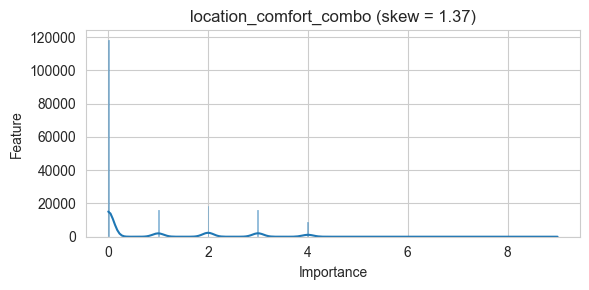

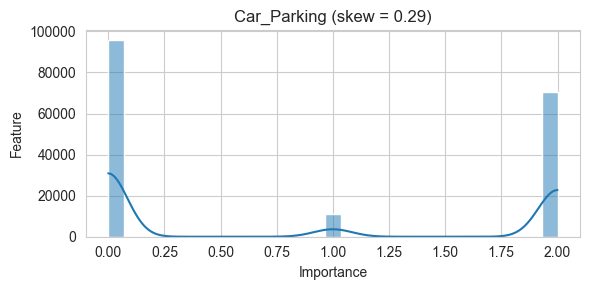

step6---特征值和目标变量的相关性


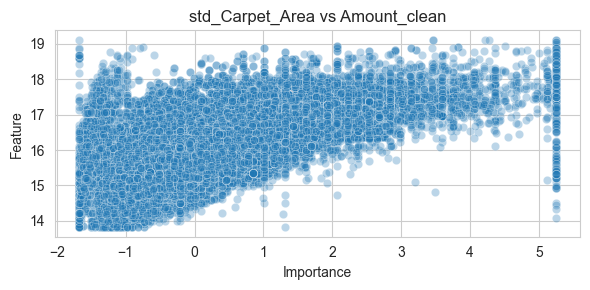

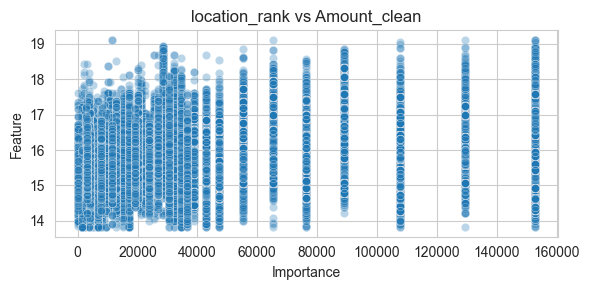

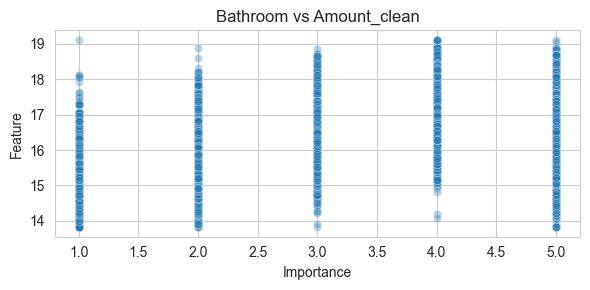

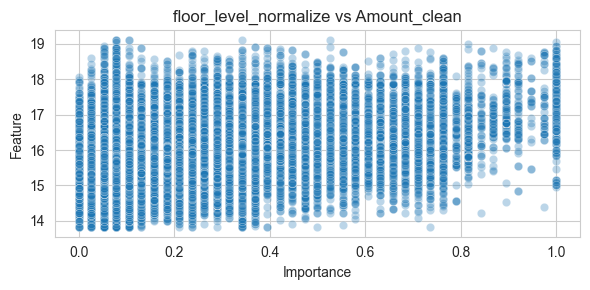

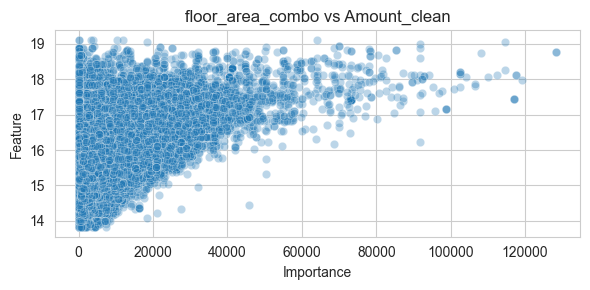

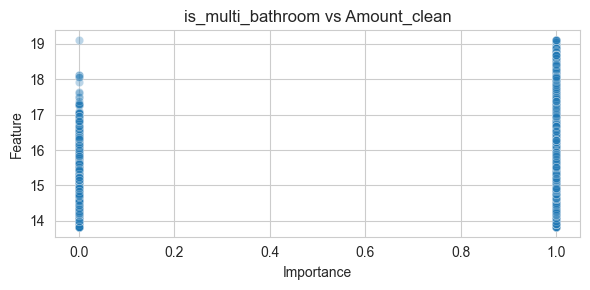

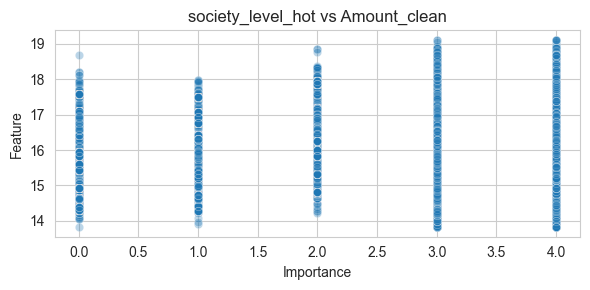

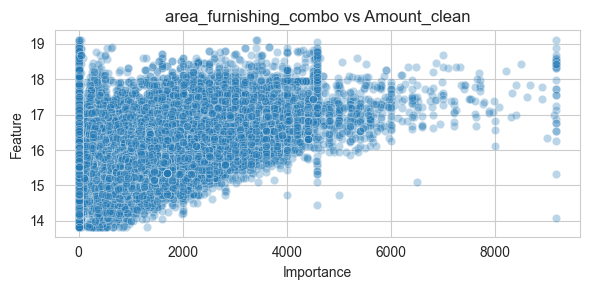

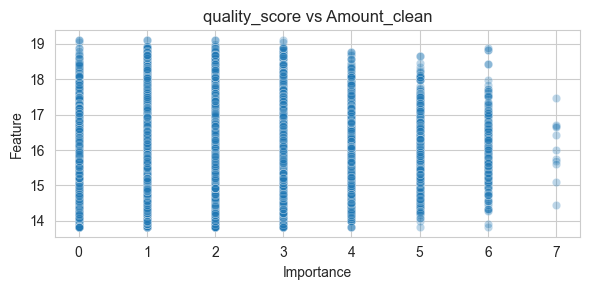

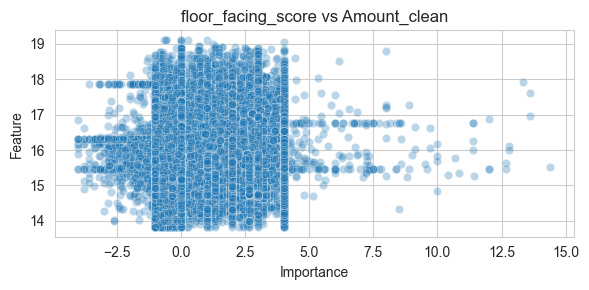

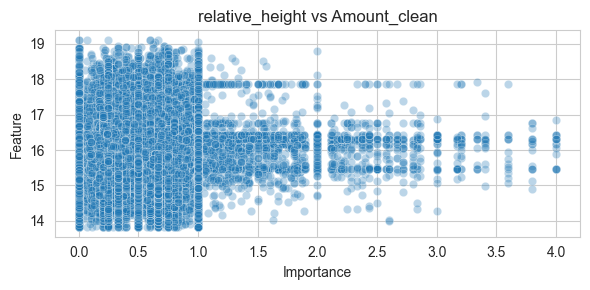

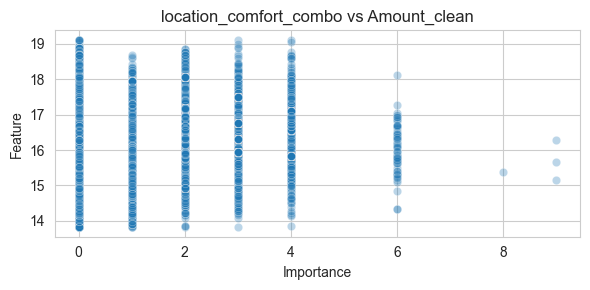

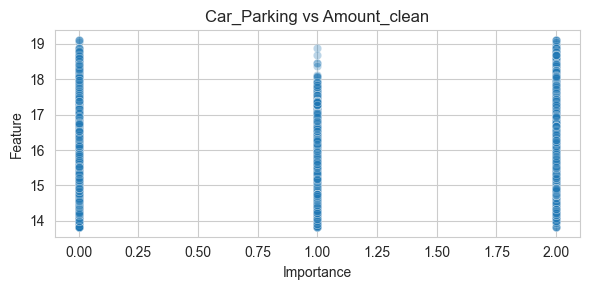

In [ ]:
#特征向量相关性 + 自动剔除高相关
print("step2---特征向量相关性") 
advanced_feature = plot_feature_correlation(df_cleaned_features, features = top_features, threshold=0.8)
print(len(advanced_feature))
#VIF检验 + 自动剔除高度VIF
print("step3---VIF检验")
advanced_features_ultimate = check_multicollinearity(df_cleaned_features, features=advanced_feature, threshold=8)
print(len(advanced_features_ultimate))
#特征值重要性排序
print("step4---特征值重要性排序")
deep_analysis = FeatureDeepAnalysis(df_cleaned, features=advanced_features_ultimate, model_cls = model_cls_used, target_col="Amount_clean")
deep_analysis.plot_feature_importance()
#特征值画图
print("step5---特征值画图")
deep_analysis.plot_feature_distribution()
#特征值和目标变量的相关性
print("step6---特征值和目标变量的相关性")
deep_analysis.plot_feature_vs_target()

In [10]:
print('\n'.join(str(f) for f in advanced_features_ultimate))

std_Carpet_Area
location_rank
Bathroom
floor_level_normalize
floor_area_combo
is_multi_bathroom
society_level_hot
area_furnishing_combo
quality_score
floor_facing_score
relative_height
location_comfort_combo
Car_Parking


In [ ]:
after_trained_model, X_test, y_test,X_train, y_train = train_model(df_cleaned_features,
     df_cleaned, features_to_use = advanced_features_ultimate, model_cls = model_cls_used) 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 142057, number of used features: 13
[LightGBM] [Info] Start training from score 15.924054
✅ 模型训练完成，保存到： models_saved/rf_model.pkl


Train Model 

Evaulate Model & Parameter optimization

In [12]:
#简单评估
evaluate_model(after_trained_model, X_test, y_test)



MAE: 0.14
RMSE: 0.24
R² Score: 0.9143


{'MAE': 0.14364060500617815,
 'RMSE': 0.2375090831825844,
 'R2': 0.9142702608433577}

In [ ]:
#grid_search (进行网格化调参)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# 1. 定义模型和参数网格
model = model_cls_used(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# 2. 初始化 GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='r2',  # or 'neg_mean_squared_error', etc.
    cv=5,
    n_jobs=-1,
    verbose=2
)

# 3. 拟合数据
grid_search.fit(X_train, y_train)

# 4. 查看最优结果
print("✅ 最优参数：", grid_search.best_params_)
print("📊 最优得分：", grid_search.best_score_)

# 5. 在测试集上评估
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("🎯 测试集 R2：", r2_score(y_test, y_pred))


Fitting 5 folds for each of 12 candidates, totalling 60 fits


✅ 最优参数： {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
📊 最优得分： 0.9318100588766203
🎯 测试集 R2： 0.9319035583721391


In [14]:

#交叉检验稳定性

In [15]:
df_cross_evaluation = enhanced_cross_validate(
    model = RandomForestRegressor(
        max_depth=None,
        min_samples_split=2,
        n_estimators=200
    ),
    features = df_cleaned[advanced_features_ultimate],
    target_col = df_cleaned["Amount_clean"].values,
    return_df = True
)

print("交叉检验结果如下：", df_cross_evaluation)


📊 5-折交叉验证结果:
🔹 MAE : 0.0948 ± 0.0006
🔹 MSE : 0.0437 ± 0.0008
🔹 R2  : 0.9340 ± 0.0014
交叉检验结果如下：      fit_time  score_time  test_MAE  test_MSE   test_R2
0  191.854236    2.056821 -0.095439 -0.044694  0.932076
1  160.496130    1.346304 -0.095272 -0.044461  0.933007
2  137.735307    1.556704 -0.094764 -0.043208  0.934710
3  136.290009    1.396705 -0.093924 -0.043478  0.934652
4  137.413520    1.470956 -0.094666 -0.042814  0.935331
